In [3]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.analysis import *
from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile

from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from pref_voting.probabilistic_methods import *
from tqdm.notebook import tqdm
import nashpy as nash
import numpy as np

from multiprocess import Pool, cpu_count, current_process


In [11]:
def x(t): 
    return [np.random.uniform(), np.random.uniform()]

p = Pool(4)

print(list(p.map(x, range(4))))


[[0.417022004702574, 0.7203244934421581], [0.417022004702574, 0.7203244934421581], [0.417022004702574, 0.7203244934421581], [0.417022004702574, 0.7203244934421581]]


In [3]:
df = condorcet_efficiency_data([plurality, split_cycle],
    numbers_of_candidates=[3],
    numbers_of_voters=[4],
    probmods=["IC"],
    num_trials=10,
    use_parallel=True,
    num_cpus=5,
)

df

3 candidates, 4 voters
data  [{'has_cw': True, 'cw_winner': {'Plurality': True, 'Split Cycle': True}}, {'has_cw': True, 'cw_winner': {'Plurality': True, 'Split Cycle': True}}, {'has_cw': True, 'cw_winner': {'Plurality': True, 'Split Cycle': True}}, {'has_cw': True, 'cw_winner': {'Plurality': True, 'Split Cycle': True}}, {'has_cw': True, 'cw_winner': {'Plurality': True, 'Split Cycle': True}}, {'has_cw': False, 'cw_winner': {'Plurality': False, 'Split Cycle': False}}, {'has_cw': False, 'cw_winner': {'Plurality': False, 'Split Cycle': False}}, {'has_cw': False, 'cw_winner': {'Plurality': False, 'Split Cycle': False}}, {'has_cw': False, 'cw_winner': {'Plurality': False, 'Split Cycle': False}}, {'has_cw': False, 'cw_winner': {'Plurality': False, 'Split Cycle': False}}]


,vm,num_cands,num_voters,probmod,num_trials,percent_condorcet_winners,condorcet_efficiency
0,Plurality,3,4,IC,10,0.5,1.0
1,Split Cycle,3,4,IC,10,0.5,1.0


(array([1, 0]), array([[0.25, 0.  ],
       [0.  , 0.25]]), 3)
[1 0]
(array([-1,  0]), array([[0.25, 0.  ],
       [0.  , 0.25]]), 3)
[-1  0]


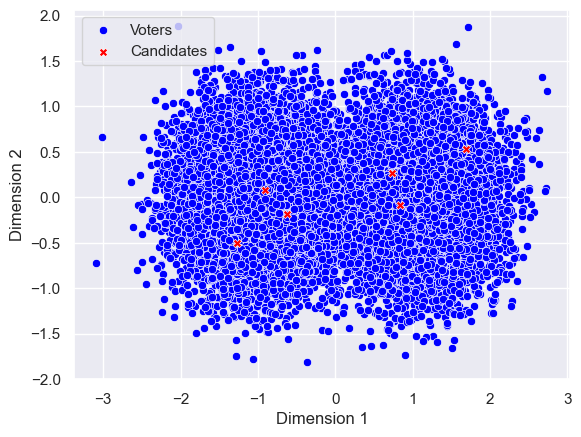

In [34]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,0]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,0]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 10000)]
    
    )



sp.view()

(array([1, 1]), array([[0.25, 0.  ],
       [0.  , 0.25]]), 3)
[1 1]
(array([-1, -1]), array([[0.25, 0.  ],
       [0.  , 0.25]]), 3)
[-1 -1]


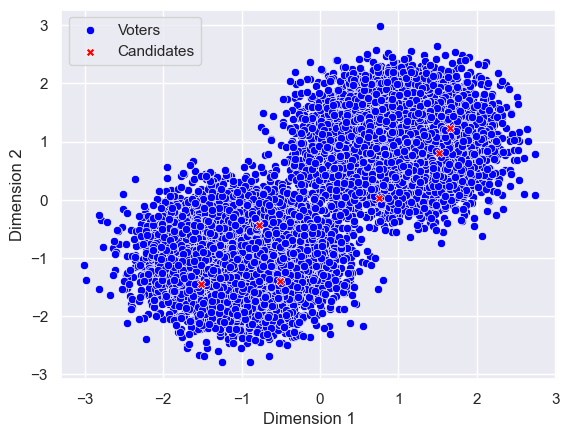

In [33]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,1]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,1]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 10000)]
    
    )

sp.view()

In [25]:
x = np.random.random(100)
y = np.random.random(100)


print("np.average(x)* np.average(y)", np.average(x) * np.average(y))
print("np.average(x * y)", np.average(x * y))
print()

print("np.average(x) / np.average(y)", np.average(x) / np.average(y))
print("np.average(x/y)", np.average(x/y))
print()

print("np.average(x) + np.average(y)", np.average(x) + np.average(y))
print("np.average(x +  y)", np.average(x + y))
print()

print("np.average(x) - np.average(y)", np.average(x) - np.average(y))
print("np.average(x - y)", np.average(x - y))


np.average(x)* np.average(y) 0.239414588915095
np.average(x * y) 0.2375136701334874

np.average(x) / np.average(y) 1.0114062886603215
np.average(x/y) 7.415116097126845

np.average(x) + np.average(y) 0.9786159374513097
np.average(x +  y) 0.9786159374513095

np.average(x) - np.average(y) 0.005549538118226338
np.average(x - y) 0.005549538118226279


In [8]:
for t in tqdm(range(1000)): 

    prof = generate_profile(6, 500)

    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)

    river_ws = river_zt(prof)

    if cw is not None and [cw] != river_ws:
        print("ERROR")
        print("river: ", river_ws)
        print("cw: ", cw)
        prof.display_margin_graph()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
for t in tqdm(range(1000)): 

    prof = generate_profile(10, 1001)

    s_set = smith_set(prof)
    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)
    if (cw is not None and woodall_ws != [cw]) or any([w not in s_set for w in woodall_ws]): 
        print("ERROR")
        print("cw: ", cw)
        print("s_set: ", s_set)
        print("woodall_ws: ", woodall_ws)

  0%|          | 0/1000 [00:00<?, ?it/s]

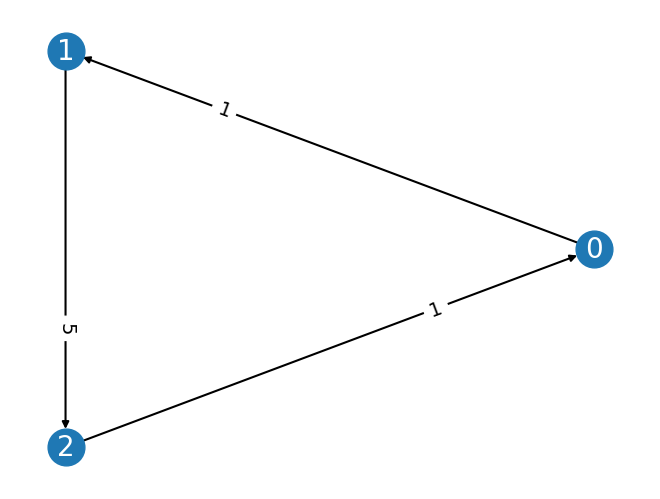

Copeland winners are {0, 1, 2}
{0: 0.33333333333333337, 1: 0.33333333333333337, 2: 0.3333333333333333}
[0, 1, 2]
{0: 0.7142857142857144, 1: 0.14285714285714282, 2: 0.14285714285714277}
[0, 1, 2]


In [10]:
prof = generate_profile(3, 21)
prof.display_margin_graph()
copeland.display(prof)
print(c1_maximal_lottery(prof))
print(bipartisan(prof))
print(maximal_lottery(prof))
print(essential(prof))



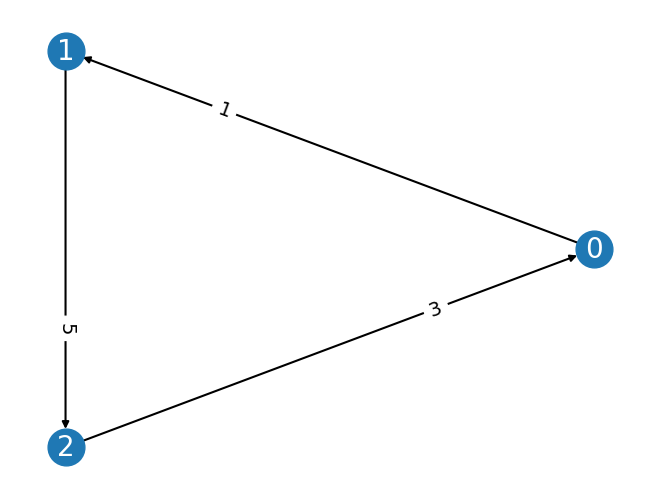

Zero sum game with payoff matrices:

Row player:
[[ 0  1 -3]
 [-1  0  5]
 [ 3 -5  0]]

Column player:
[[ 0 -1  3]
 [ 1  0 -5]
 [-3  5  0]]
(array([0.55555556, 0.33333333, 0.11111111]), array([0.55555556, 0.33333333, 0.11111111]))


In [7]:
mg = MarginGraph(
    [0, 1,2 ],
    [(0, 1, 1), 
    (1, 2, 5), 
    (2, 0, 3)]
)
mg.display()

A = np.array(mg.margin_matrix)

# Create the game
game = nash.Game(A)
print(game)
# Find the Nash Equilibrium with Support Enumeration
equilibria = game.support_enumeration()
for eq in equilibria:
    print(eq)



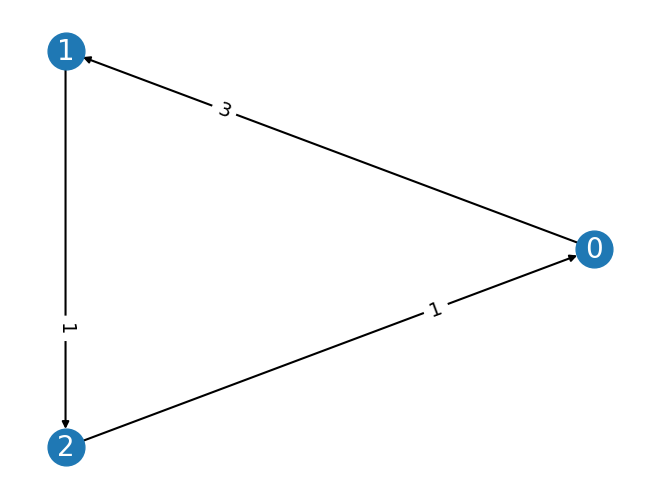

[[0, 3, -1], [-3, 0, 1], [1, -1, 0]]
Zero sum game with payoff matrices:

Row player:
[[ 0  3 -1]
 [-3  0  1]
 [ 1 -1  0]]

Column player:
[[ 0 -3  1]
 [ 3  0 -1]
 [-1  1  0]]
(array([0.2, 0.2, 0.6]), array([0.2, 0.2, 0.6]))


In [21]:


for t in range(1000): 

    prof = generate_profile(3, 5)
    if prof.condorcet_winner() is None:
        prof.display_margin_graph()

        print(prof.margin_graph().margin_matrix)
        # Define the payoff matrix for players
        # A and B should be square matrices where the dimension is equal to the number of actions
        A = np.array(prof.margin_matrix)
        B = -A  # For zero sum games, player 2's payoff matrix is the negative of player 1's

        # Create the game
        game = nash.Game(A)
        print(game)
        # Find the Nash Equilibrium with Support Enumeration
        equilibria = game.support_enumeration()
        for eq in equilibria:
            print(eq)

        break


In [30]:
for t in tqdm(range(1000)): 
    prof = generate_spatial_profile(10, 1001, 2).to_utility_profile().to_ranking_profile().to_linear_profile()

    A = np.array(prof.margin_matrix)

    game = nash.Game(A)
    equilibria = list(game.vertex_enumeration())

    if len(equilibria) != 1: 
        prof.display_margin_graph()
        print(prof.margin_matrix)
        print(equilibria)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
prof = generate_profile(4, 4)

prof.display()
print(prof.borda_scores())


print(random_dictator(prof))
print(random_dictator.name)
print(pr_borda(prof))

+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 1 | 2 |
| 3 | 3 | 0 | 1 |
| 2 | 1 | 3 | 0 |
| 0 | 2 | 2 | 3 |
+---+---+---+---+
{0: 6, 1: 9, 2: 4, 3: 5}
{0: 0.25, 1: 0.5, 2: 0.25, 3: 0.0}
Random Dictator
{0: 0.25, 1: 0.375, 2: 0.16666666666666666, 3: 0.20833333333333334}


In [10]:
uprof = UtilityProfile([{0: u, 1: 20*u, 2: 30*u} for u in  [50, 60, 70, 80, 90, 100, 110]])

uprof.display()

uprof.normalize_by_range().display()

uprof.normalize_by_standard_score().display()

util_avg = uprof.avg_utility_function()

for x in uprof.domain: 
    print(x, util_avg(x))

  Voter    0     1     2
-------  ---  ----  ----
      1   50  1000  1500
      2   60  1200  1800
      3   70  1400  2100
      4   80  1600  2400
      5   90  1800  2700
      6  100  2000  3000
      7  110  2200  3300
  Voter    0         1    2
-------  ---  --------  ---
      1    0  0.655172    1
      2    0  0.655172    1
      3    0  0.655172    1
      4    0  0.655172    1
      5    0  0.655172    1
      6    0  0.655172    1
      7    0  0.655172    1
  Voter         0         1        2
-------  --------  --------  -------
      1  -1.33026  0.249423  1.08083
      2  -1.33026  0.249423  1.08083
      3  -1.33026  0.249423  1.08083
      4  -1.33026  0.249423  1.08083
      5  -1.33026  0.249423  1.08083
      6  -1.33026  0.249423  1.08083
      7  -1.33026  0.249423  1.08083
0 80.0
1 1600.0
2 2400.0


In [19]:
up = generate_spatial_profile(3, 3, 2).to_utility_profile()

up.display()
up.normalize_by_range().display()

up.normalize_by_standard_score().display()

  Voter           0         1         2
-------  ----------  --------  --------
      1   -0.056049  -2.01094  -8.98789
      2  -14.2637    -8.721    -1.85585
      3   -4.84009   -5.57519  -6.60548
  Voter    0         1    2
-------  ---  --------  ---
      1    1  0.781132    0
      2    0  0.44671     1
      3    1  0.583602    0
  Voter          0           1          2
-------  ---------  ----------  ---------
      1   1.07253    1.24939    -1.06978
      2  -1.33455   -1.19851     1.33594
      3   0.262015  -0.0508847  -0.266163


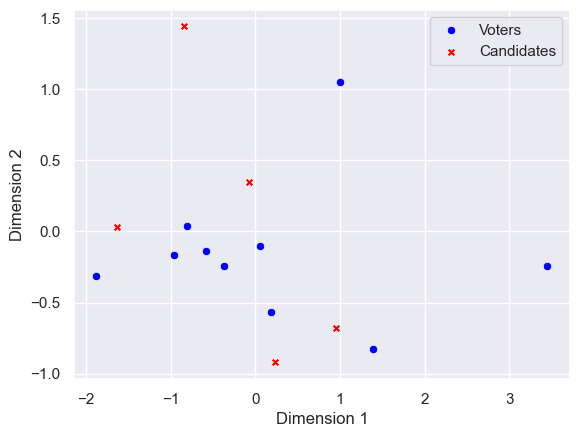

In [5]:
sp = generate_spatial_profile(5, 10, 2)

sp.view()

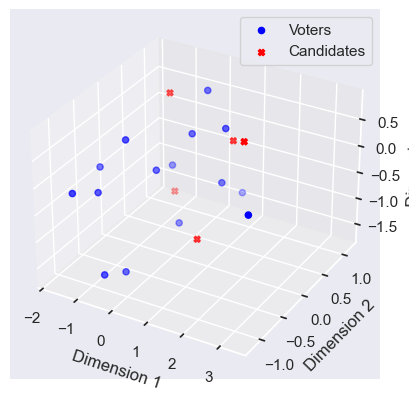

Candidates: 
Candidate  0  position:  [ 2.1033218  -0.09058368  0.75997998]
Candidate  1  position:  [-0.56599997  0.38700838  0.85877957]
Candidate  2  position:  [1.25943948 0.36397272 0.31181085]
Candidate  3  position:  [-0.47764635  0.40985835 -1.00220342]
Candidate  4  position:  [ 1.14819134 -0.35654628 -1.03144389]

Voters: 
Voter  0  position:  [-0.3262789  -0.10820523 -0.20028459]
Voter  1  position:  [-1.3691553  -1.09697636 -0.11785441]
Voter  2  position:  [-1.75245953 -0.26393699 -0.29441355]
Voter  3  position:  [-0.3977667  -0.73491132 -1.67861726]
Voter  4  position:  [-1.16130161 -0.72861851 -0.33061378]
Voter  5  position:  [1.03387605 0.37223595 0.49096111]
Voter  6  position:  [ 0.83686662  0.45108524 -0.61852516]
Voter  7  position:  [ 0.59496188  1.14534436 -1.36362685]
Voter  8  position:  [0.06022831 0.74289477 0.78029967]
Voter  9  position:  [0.10188186 0.35799562 0.2371802 ]
Voter  10  position:  [-0.18234584  0.27604862 -1.46642002]
Voter  11  position:  [ 

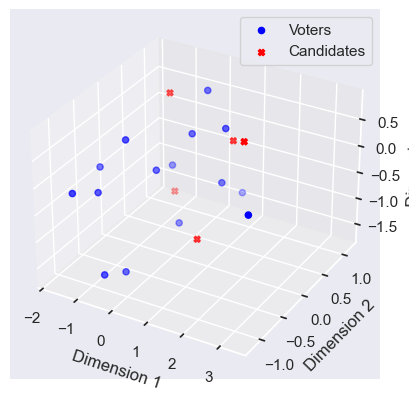

Candidates: 
Candidate  0  position:  [ 2.1033218  -0.09058368  0.75997998]
Candidate  1  position:  [-0.56599997  0.38700838  0.85877957]
Candidate  2  position:  [1.25943948 0.36397272 0.31181085]
Candidate  3  position:  [-0.47764635  0.40985835 -1.00220342]
Candidate  4  position:  [ 1.14819134 -0.35654628 -1.03144389]

Voters: 
Voter  0  position:  [-0.3262789  -0.10820523 -0.20028459]
Voter  1  position:  [-1.3691553  -1.09697636 -0.11785441]
Voter  2  position:  [-1.75245953 -0.26393699 -0.29441355]
Voter  3  position:  [-0.3977667  -0.73491132 -1.67861726]
Voter  4  position:  [-1.16130161 -0.72861851 -0.33061378]
Voter  5  position:  [1.03387605 0.37223595 0.49096111]
Voter  6  position:  [ 0.83686662  0.45108524 -0.61852516]
Voter  7  position:  [ 0.59496188  1.14534436 -1.36362685]
Voter  8  position:  [0.06022831 0.74289477 0.78029967]
Voter  9  position:  [0.10188186 0.35799562 0.2371802 ]
Voter  10  position:  [-0.18234584  0.27604862 -1.46642002]
Voter  11  position:  [ 

In [6]:
sp = generate_spatial_profile(5, 15, 3)
sp.view()
sp.display()
sp_str = sp.write()

sp2 = SpatialProfile.from_string(sp_str)

sp2.view()
sp2.display()


In [7]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    print(split_cycle(prof)  ) 

[2]
[0]
[3]
[3]
[3]
[1, 2]
[0]
[1, 3]
[0]
[1]
[2]
[3]
[1]
[0]
[3]
[0]
[0]
[0]
[2]
[1]
[0]
[3]
[0]
[0]
[2]
[1, 3]
[3]
[1]
[1]
[0]
[3]
[2]
[1]
[1]
[3]
[3]
[1]
[1]
[0]
[2]
[3]
[3]
[3]
[0]
[1, 3]
[1]
[2]
[1]
[3]
[2]
[3]
[3]
[3]
[0]
[1]
[2]
[1]
[0]
[1]
[3]
[0]
[3]
[0]
[1]
[3]
[0]
[0, 1, 2, 3]
[1, 2]
[2]
[0]
[3]
[0]
[0]
[2]
[0]
[1]
[0]
[0, 1, 2]
[2]
[0]
[1]
[3]
[1]
[0]
[0]
[0]
[3]
[0]
[3]
[1, 2, 3]
[3]
[3]
[1]
[1, 2]
[1]
[2]
[3]
[1]
[3]
[2]


In [8]:

for t in range(100):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               iterated_split_cycle,
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()




Split Cycle winner is {4}
Split Cycle winner is {2}
Stable Voting winner is {0}
Stable Voting winner is {3}
Beat Path winners are {2, 4}
Beat Path winner is {1}
Beat Path winner is {1}
Beat Path winners are {1, 4}
Split Cycle winner is {4}
Split Cycle winner is {1}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {0}
Iterated Split Cycle winner is {4}
Iterated Split Cycle winner is {0}
Copeland winner is {2}
Copeland winner is {3}
Borda winner is {1}
Borda winner is {3}
Plurality winners are {0, 2}
Plurality winner is {3}
PluralityWRunoff winner is {3}
PluralityWRunoff winners are {3, 4}
Instant Runoff winner is {1}
Instant Runoff winner is {4}
Coombs winner is {1}
Coombs winners are {1, 3}
Minimax winner is {3}
Minimax winner is {0}
Strict Nanson winner is {4}
Strict Nanson winner is {4}
Bucklin winner is {0}
Bucklin winner is {3}

Split Cycle winner is {3}
Split Cycle winners are {0, 1}
Stable Voting winner is {2}
Stable Voting winner is {1}
Beat Path winner is {4}
B

In [9]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winners are {0, 2, 3}
Split Cycle winners are {0, 3}
Beat Path winner is {2}
Beat Path winner is {4}
Beat Path winner is {2}
Beat Path winners are {0, 2, 4}
Split Cycle winner is {3}
Split Cycle winner is {0}
Plurality winners are {2, 3, 4}
Plurality winner is {3}
Stable Voting winner is {4}
Stable Voting winner is {4}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {0}
Copeland winner is {1}
Copeland winner is {3}
Borda winner is {2}
Borda winner is {4}
Instant Runoff winner is {2}
Instant Runoff winner is {4}

Split Cycle winners are {2, 4}
Split Cycle winners are {1, 2}
Beat Path winners are {1, 2}
Beat Path winner is {3}
Beat Path winner is {2}
Beat Path winner is {2}
Split Cycle winner is {1}
Split Cycle winner is {4}
Plurality winners are {0, 1}
Plurality winner is {1}
Stable Voting winner is {0}
Stable Voting winner is {4}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {0}
Copeland winner is {4}
Copeland winners are {0, 1}
Borda w

In [10]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)


        ws_restricted = vm(mg, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winners are {0, 3}
Split Cycle winner is {0}
Split Cycle winner is {1}
Beat Path winner is {0}
Beat Path winner is {1}
Beat Path winner is {4}
Beat Path winner is {3}
Beat Path winner is {3}
Beat Path winner is {4}
Split Cycle winner is {1}
Split Cycle winner is {2}
Split Cycle winner is {1}
Stable Voting winner is {1}
Stable Voting winner is {0}
Stable Voting winner is {2}
Simple Stable Voting winner is {2}
Simple Stable Voting winner is {1}
Simple Stable Voting winner is {4}
GOCHA winner is {4}
GOCHA winners are {0, 1, 2, 3}
GOCHA winner is {3}
Smith Set winners are {0, 1, 2, 3, 4}
Smith Set winner is {1}
Smith Set winners are {0, 2, 3}
Copeland winners are {0, 3}
Copeland winners are {0, 3}
Copeland winners are {0, 2, 3}

Split Cycle winners are {3, 4}
Split Cycle winner is {1}
Split Cycle winner is {1}
Beat Path winner is {0}
Beat Path winner is {3}
Beat Path winner is {4}
Beat Path winner is {0}
Beat Path winner is {0}
Beat Path winner is {0}
Split Cycle winner is {1}


In [11]:
for t in range(100):
    for um in [sum_utilitarian,
                relative_utilitarian,
                maximin,
                lexicographic_maximin,
                nash,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        print(um(uprof))

        uprof = generate_utility_profile_normal(6, 20)
        print(um(uprof))

        uprof = generate_spatial_utility_profile(5, 11)
        print(um(uprof))

    print()


3 1 4 2 0 
0 4 3 2 5 1 
3 4 1 2 0 
2 3 1 0 4 
4 1 5 3 0 2 
1 0 4 2 3 
2 3 0 4 1 
0 5 4 1 2 3 
0 1 3 4 2 
2 0 1 3 4 
2 4 5 1 3 0 
2 0 3 4 1 
0 
0 
0 

4 0 3 2 1 
0 1 4 2 5 3 
4 3 2 1 0 
0 4 2 1 3 
5 4 2 3 0 1 
4 2 3 0 1 
0 1 2 3 4 
2 5 4 0 3 1 
3 2 0 4 1 
3 0 1 2 4 
3 5 1 4 2 0 
2 1 0 4 3 
0 
0 
0 

4 1 2 0 3 
5 4 2 0 1 3 
1 3 2 4 0 
1 2 0 3 4 
1 4 3 0 5 2 
0 4 2 1 3 
2 0 1 4 3 
0 1 4 2 3 5 
0 4 1 3 2 
4 3 2 0 1 
3 4 0 5 1 2 
0 3 4 1 2 
0 
1 3 5 2 0 
0 

3 0 4 1 2 
0 5 1 4 2 3 
4 1 2 0 3 
2 1 3 0 4 
5 2 1 3 0 4 
2 1 0 4 3 
4 2 0 3 1 
0 5 2 3 1 4 
2 3 0 4 1 
2 4 3 0 1 
1 0 4 2 5 3 
4 3 0 1 2 
0 
0 
0 

2 0 3 1 4 
1 0 5 3 4 2 
4 2 3 0 1 
2 1 4 3 0 
0 1 4 3 2 5 
2 3 0 1 4 
1 3 0 4 2 
3 4 0 2 1 5 
3 4 1 0 2 
2 4 0 1 3 
5 0 1 2 3 4 
3 2 4 1 0 
0 
0 
0 

3 4 1 2 0 
5 3 0 2 4 1 
1 0 4 3 2 
4 0 2 1 3 
1 5 2 4 3 0 
2 3 1 0 4 
0 4 3 2 1 
5 4 3 0 2 1 
3 1 0 2 4 
1 4 2 0 3 
2 3 1 5 0 4 
2 3 4 1 0 
0 
3 1 4 0 
0 

3 4 1 2 0 
3 1 0 5 4 2 
1 0 4 2 3 
1 3 4 2 0 
5 2 3 1 0 4 
4 2 1 3 0 
0 1 2 4 3 
2 0 3

In [12]:
for t in range(100):
    for vm in [sum_utilitarian_ws,
                relative_utilitarian_ws,
                maximin_ws,
                lexicographic_maximin_ws,
                nash_ws,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        vm.display(uprof)

        uprof = generate_utility_profile_normal(6, 20)
        vm.display(uprof)

        uprof = generate_spatial_utility_profile(5, 11)
        vm.display(uprof)

        ws_restricted = vm(uprof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()


Sum Utilitarianism winner is {3}
Sum Utilitarianism winner is {1}
Sum Utilitarianism winner is {2}
Relative Utilitarianism winner is {3}
Relative Utilitarianism winner is {3}
Relative Utilitarianism winner is {0}
Maximin winner is {4}
Maximin winner is {4}
Maximin winner is {4}
Lexicographic Maximin winner is {3}
Lexicographic Maximin winner is {5}
Lexicographic Maximin winner is {4}
Nash winner is {0}
Nash winner is {0}
Nash winner is {0}

Sum Utilitarianism winner is {3}
Sum Utilitarianism winner is {2}
Sum Utilitarianism winner is {0}
Relative Utilitarianism winner is {4}
Relative Utilitarianism winner is {4}
Relative Utilitarianism winner is {4}
Maximin winner is {2}
Maximin winner is {5}
Maximin winner is {0}
Lexicographic Maximin winner is {1}
Lexicographic Maximin winner is {3}
Lexicographic Maximin winner is {2}
Nash winner is {0}
Nash winner is {1}
Nash winner is {2}

Sum Utilitarianism winner is {0}
Sum Utilitarianism winner is {2}
Sum Utilitarianism winner is {0}
Relative Ut